In [9]:
!pip install tensorflow keras 

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import tensorflow as tf
import random

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's random module
random.seed(42)


Only run the next cell if the data has not been split into training and validation

In [78]:
import os
import shutil
import random

# Set random seed
random.seed(42)

# Define paths
data_dir = 'data/'
train_dir = 'train/'
test_dir = 'test/'

# Clear train and test directories
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get list of image filenames in each class folder
malignant_images = os.listdir(os.path.join(data_dir, 'malignant'))
normal_images = os.listdir(os.path.join(data_dir, 'normal'))

# Shuffle the filenames
random.shuffle(malignant_images)
random.shuffle(normal_images)

# Define the number of images for training and testing
train_count = 200
test_count = 50

# Split images into training and testing sets
malignant_train_images = malignant_images[:train_count]
malignant_test_images = malignant_images[train_count:train_count+test_count]

normal_train_images = normal_images[:train_count]
normal_test_images = normal_images[train_count:train_count+test_count]

# Copy images to train and test folders
for img in malignant_train_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_train = os.path.join(train_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in malignant_test_images:
    src = os.path.join(data_dir, 'malignant', img)
    dst_test = os.path.join(test_dir, 'malignant', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

for img in normal_train_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_train = os.path.join(train_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_train), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_train)

for img in normal_test_images:
    src = os.path.join(data_dir, 'normal', img)
    dst_test = os.path.join(test_dir, 'normal', img)
    os.makedirs(os.path.dirname(dst_test), exist_ok=True)  # Create destination directory if it doesn't exist
    shutil.copyfile(src, dst_test)

print("Data copied successfully.")


Data copied successfully.


Setting up target size 

In [79]:
import os

# Define directories
train_dir = 'train/'
test_dir = 'test/'

# Count number of files in train directory
train_malignant_count = len(os.listdir(os.path.join(train_dir, 'malignant')))
train_normal_count = len(os.listdir(os.path.join(train_dir, 'normal')))

# Count number of files in test directory
test_malignant_count = len(os.listdir(os.path.join(test_dir, 'malignant')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'normal')))

# Print counts
print("Train directory:")
print(f"Malignant: {train_malignant_count} images")
print(f"Normal: {train_normal_count} images")

print("\nTest directory:")
print(f"Malignant: {test_malignant_count} images")
print(f"Normal: {test_normal_count} images")


Train directory:
Malignant: 200 images
Normal: 200 images

Test directory:
Malignant: 50 images
Normal: 50 images


In [80]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Define image dimensions and other parameters
img_height = 128
img_width = 128
batch_size = 32
epochs = 10

# Create ImageDataGenerators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')






Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [120]:
import tensorflow as tf
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, optimizer='adam', epochs=10, batch_size=32, verbose=1):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.compile(optimizer=self.optimizer,
                           loss='binary_crossentropy',
                           metrics=['accuracy'])
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype('int32')

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [121]:

from sklearn.model_selection import GridSearchCV

# Define CNN model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

# Wrap Keras model in a scikit-learn compatible classifier
model = CustomKerasClassifier(build_fn=create_model, verbose=0)




In [122]:

# Define hyperparameters for grid search
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'optimizer': ['adam', 'sgd']
}

# Load the images
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

# Grid search
grid_search = GridSearchCV(estimator=CustomKerasClassifier(create_model), param_grid=param_grid, cv=5)
grid_search.fit(train_images, train_labels)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
test_accuracy = best_model.score(test_images, test_labels)
print("Test Accuracy:", test_accuracy)


Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6000 - loss: 0.6813
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6800 - loss: 0.8475
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6800 - loss: 0.4946
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6800 - loss: 0.4866
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6800 - loss: 0.4574
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6800 - loss: 0.4315
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8400 - loss: 0.4063
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8400 - loss: 0.3800
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8400 - loss: 0.3694
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8400 - loss: 0.3565
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6400 - loss: 0.6546
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6400 - loss: 1.7770
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6400 - loss: 0.6200
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7200 - loss: 0.5328
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7200 - loss: 0.5548
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6400 - loss: 0.4821
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6400 - loss: 0.5710
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8000 - loss: 0.4585
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6400 - loss: 0.4395
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9600 - loss: 0.4404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6912
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6538 - loss: 0.9864
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6538 - loss: 0.5660
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6538 - loss: 0.5624
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5501
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5089
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6538 - loss: 0.5224
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6538 - loss: 0.4671
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6538 - loss: 0.4537
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8077 - loss: 0.4440
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5769 - loss: 0.6869
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6538 - loss: 0.8184
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6538 - loss: 0.5286
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6538 - loss: 0.5300
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6538 - loss: 0.5268
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6538 - loss: 0.4900
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6538 - loss: 0.4735
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6538 - loss: 0.4543
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8077 - loss: 0.4278
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8077 - loss: 0.4100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6923 - loss: 0.6797
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6538 - loss: 1.2905
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6538 - loss: 0.5960
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6538 - loss: 0.5356
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6538 - loss: 0.5478
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6538 - loss: 0.5014
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6538 - loss: 0.4757
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6538 - loss: 0.4604
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6538 - loss: 0.4302
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8077 - loss: 0.4129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6400 - loss: 0.6645
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6800 - loss: 0.6486
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6800 - loss: 0.6346
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6800 - loss: 0.6217
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6800 - loss: 0.6095
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6800 - loss: 0.5984
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6800 - loss: 0.5882
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6800 - loss: 0.5791
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6800 - loss: 0.5708
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6800 - loss: 0.5631
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6000 - loss: 0.6838
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6400 - loss: 0.6764
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6400 - loss: 0.6695
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6400 - loss: 0.6629
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6400 - loss: 0.6564
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6400 - loss: 0.6502
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.6400 - loss: 0.6441
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6400 - loss: 0.6380
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6400 - loss: 0.6318
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6400 - loss: 0.6255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4231 - loss: 0.6928
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6154 - loss: 0.6723
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6538 - loss: 0.6571
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6538 - loss: 0.6450
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6538 - loss: 0.6351
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6538 - loss: 0.6271
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6538 - loss: 0.6204
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6538 - loss: 0.6146
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6538 - loss: 0.6096
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6538 - loss: 0.6052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6538 - loss: 0.6462
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6538 - loss: 0.6150
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.6538 - loss: 0.5933
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6538 - loss: 0.5786
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.6538 - loss: 0.5675
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6538 - loss: 0.5591
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6538 - loss: 0.5524
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6538 - loss: 0.5468
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6538 - loss: 0.5419
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6538 - loss: 0.5375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5769 - loss: 0.6807
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.6538 - loss: 0.6576
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6538 - loss: 0.6391
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.6538 - loss: 0.6242
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6538 - loss: 0.6118
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6538 - loss: 0.6014
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6538 - loss: 0.5924
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6538 - loss: 0.5847
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6538 - loss: 0.5781
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6538 - loss: 0.5724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6000 - loss: 0.6869
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6800 - loss: 0.5979
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6800 - loss: 0.4871
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.6800 - loss: 0.4580
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6800 - loss: 0.4275
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6800 - loss: 0.4124
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6800 - loss: 0.3947
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8400 - loss: 0.3838
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.8400 - loss: 0.3773
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8400 - loss: 0.3707
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.8400 - loss: 0.3643
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8400 - loss:

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3200 - loss: 0.7016
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.6400 - loss: 0.7921
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6400 - loss: 0.5283
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6400 - loss: 0.5090
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6400 - loss: 0.4903
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6400 - loss: 0.4609
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6400 - loss: 0.4482
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8000 - loss: 0.4255
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8000 - loss: 0.4141
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8000 - loss: 0.4039
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.8000 - loss: 0.3922
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8000 - loss:

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4231 - loss: 0.6938
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6538 - loss: 0.8905
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6538 - loss: 0.5577
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.6538 - loss: 0.5558
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.6538 - loss: 0.5322
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.6538 - loss: 0.4929
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.6538 - loss: 0.4936
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.6538 - loss: 0.4479
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8077 - loss: 0.4329
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8077 - loss: 0.4201
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6538 - loss: 0.4012
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8077 - loss:

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2308 - loss: 0.7086
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.6538 - loss: 0.6927
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6538 - loss: 0.5140
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6538 - loss: 0.5077
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6538 - loss: 0.4890
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6538 - loss: 0.4583
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6538 - loss: 0.4378
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6538 - loss: 0.4181
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8077 - loss: 0.4000
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8077 - loss: 0.3842
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.8077 - loss: 0.3673
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8077 - loss:

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3462 - loss: 0.6956
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6538 - loss: 0.9234
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6538 - loss: 0.5304
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6538 - loss: 0.5362
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6538 - loss: 0.5116
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6538 - loss: 0.4722
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6538 - loss: 0.4698
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6538 - loss: 0.4296
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8077 - loss: 0.4138
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8077 - loss: 0.4059
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8077 - loss: 0.3921
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8077 - loss: 0.3735
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4800 - loss: 0.6868
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.6800 - loss: 0.6615
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.6425
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.6261
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6800 - loss: 0.6118
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6800 - loss: 0.5992
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6800 - loss: 0.5882
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6800 - loss: 0.5784
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6800 - loss: 0.5699
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6800 - loss: 0.5623
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.5557
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.5498
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5200 - loss: 0.6921
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.5600 - loss: 0.6755
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6400 - loss: 0.6617
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6400 - loss: 0.6497
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6400 - loss: 0.6389
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6400 - loss: 0.6290
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6400 - loss: 0.6200
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6400 - loss: 0.6116
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6400 - loss: 0.6036
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6400 - loss: 0.5961
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6400 - loss: 0.5891
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6400 - loss: 0.5826
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2692 - loss: 0.7005
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5000 - loss: 0.6845
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6538 - loss: 0.6715
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6538 - loss: 0.6606
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6538 - loss: 0.6512
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6538 - loss: 0.6426
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6538 - loss: 0.6351
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6538 - loss: 0.6285
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6538 - loss: 0.6226
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6538 - loss: 0.6176
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6538 - loss: 0.6130
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6538 - loss: 0.6087
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3077 - loss: 0.7011
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6154 - loss: 0.6649
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6538 - loss: 0.6391
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6538 - loss: 0.6195
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6538 - loss: 0.6039
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6538 - loss: 0.5908
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6538 - loss: 0.5794
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6538 - loss: 0.5695
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5615
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6538 - loss: 0.5548
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6538 - loss: 0.5490
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6538 - loss: 0.5440
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3462 - loss: 0.6985
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5385 - loss: 0.6790
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6538 - loss: 0.6624
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6538 - loss: 0.6482
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6538 - loss: 0.6359
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6538 - loss: 0.6253
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6538 - loss: 0.6158
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6538 - loss: 0.6072
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6538 - loss: 0.5994
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6538 - loss: 0.5929
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6538 - loss: 0.5870
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6538 - loss: 0.5814
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4400 - loss: 0.6909
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6800 - loss: 0.7269
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6800 - loss: 0.5021
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6800 - loss: 0.4842
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6800 - loss: 0.4595
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6800 - loss: 0.4284
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6800 - loss: 0.4165
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8400 - loss: 0.3891
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8400 - loss: 0.3767
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6800 - loss: 0.3687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2400 - loss: 0.7039
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6400 - loss: 0.6888
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6400 - loss: 0.5225
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6400 - loss: 0.5127
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6400 - loss: 0.4783
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6400 - loss: 0.4662
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8000 - loss: 0.4370
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8000 - loss: 0.4241
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8000 - loss: 0.4145
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8000 - loss: 0.4027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6538 - loss: 0.6731
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6538 - loss: 0.9964
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6538 - loss: 0.5558
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6538 - loss: 0.5748
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5599
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6538 - loss: 0.5138
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5394
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6538 - loss: 0.4771
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6538 - loss: 0.4630
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6538 - loss: 0.4563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5385 - loss: 0.6837
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6538 - loss: 1.1741
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6538 - loss: 0.5686
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5102
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6538 - loss: 0.5202
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6538 - loss: 0.4831
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6538 - loss: 0.4853
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8077 - loss: 0.4420
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8077 - loss: 0.4226
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6538 - loss: 0.4123
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6154 - loss: 0.6790
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6538 - loss: 1.1513
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6538 - loss: 0.5566
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6538 - loss: 0.5326
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7308 - loss: 0.5378
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.6538 - loss: 0.4896
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6538 - loss: 0.5156
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8077 - loss: 0.4479
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8077 - loss: 0.4292
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8077 - loss: 0.4207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2400 - loss: 0.7111
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.3200 - loss: 0.6958
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6000 - loss: 0.6823
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6400 - loss: 0.6703
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6800 - loss: 0.6593
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6800 - loss: 0.6492
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6800 - loss: 0.6396
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6800 - loss: 0.6301
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6800 - loss: 0.6211
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6800 - loss: 0.6127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2400 - loss: 0.7100
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4000 - loss: 0.6788
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6400 - loss: 0.6578
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6400 - loss: 0.6422
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6400 - loss: 0.6293
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6400 - loss: 0.6181
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6400 - loss: 0.6086
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6400 - loss: 0.6003
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6400 - loss: 0.5931
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6400 - loss: 0.5867
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3846 - loss: 0.6961
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6154 - loss: 0.6787
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6538 - loss: 0.6647
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6538 - loss: 0.6532
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.6538 - loss: 0.6426
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6538 - loss: 0.6333
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6538 - loss: 0.6256
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6538 - loss: 0.6187
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6538 - loss: 0.6128
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6538 - loss: 0.6075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3846 - loss: 0.6931
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6154 - loss: 0.6673
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6538 - loss: 0.6479
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6538 - loss: 0.6315
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6538 - loss: 0.6174
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6538 - loss: 0.6051
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6538 - loss: 0.5944
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6538 - loss: 0.5855
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6538 - loss: 0.5776
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6538 - loss: 0.5707
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3846 - loss: 0.6924
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6154 - loss: 0.6772
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6538 - loss: 0.6642
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6538 - loss: 0.6528
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6538 - loss: 0.6425
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6538 - loss: 0.6333
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6538 - loss: 0.6245
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step - accuracy: 0.6538 - loss: 0.6167
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.6538 - loss: 0.6096
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6538 - loss: 0.6032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.2800 - loss: 0.7035
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6800 - loss: 0.6458
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - accuracy: 0.6800 - loss: 0.4966
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - accuracy: 0.6800 - loss: 0.4769
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6800 - loss: 0.4416
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.6800 - loss: 0.4424
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.6800 - loss: 0.3963
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6800 - loss: 0.3860
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.8400 - loss: 0.3758
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8400 - loss: 0.3659
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.8400 - loss: 0.3528
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8400 - loss:

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4800 - loss: 0.6877
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6400 - loss: 0.8602
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6400 - loss: 0.5319
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6400 - loss: 0.5242
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6400 - loss: 0.5044
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6400 - loss: 0.4678
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.8000 - loss: 0.4671
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8000 - loss: 0.4342
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8000 - loss: 0.4241
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8000 - loss: 0.4171
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8000 - loss: 0.4060
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6400 - loss: 0.3935
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1923 - loss: 0.7048
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6538 - loss: 0.9658
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6538 - loss: 0.5772
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6538 - loss: 0.5643
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6538 - loss: 0.5469
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6538 - loss: 0.5212
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6538 - loss: 0.4972
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6538 - loss: 0.4654
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6538 - loss: 0.4432
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8077 - loss: 0.4224
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6538 - loss: 0.3973
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8462 - loss: 0.3723
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3846 - loss: 0.6980
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.6538 - loss: 1.0624
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6538 - loss: 0.5545
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6538 - loss: 0.5105
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6538 - loss: 0.5184
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6538 - loss: 0.4801
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6538 - loss: 0.4626
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.6538 - loss: 0.4371
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8077 - loss: 0.4100
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8077 - loss: 0.3993
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8077 - loss: 0.3870
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.8077 - loss: 0.3737
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2692 - loss: 0.7082
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6538 - loss: 0.7260
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6538 - loss: 0.5266
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6538 - loss: 0.5060
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6538 - loss: 0.4763
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6538 - loss: 0.4609
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8077 - loss: 0.4297
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8077 - loss: 0.4110
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8077 - loss: 0.3992
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8077 - loss: 0.3860
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8077 - loss: 0.3719
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8462 - loss: 0.3527
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6800 - loss: 0.6729
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6800 - loss: 0.6574
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6800 - loss: 0.6429
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6800 - loss: 0.6294
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6800 - loss: 0.6167
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6800 - loss: 0.6048
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6800 - loss: 0.5938
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6800 - loss: 0.5838
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6800 - loss: 0.5748
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.6800 - loss: 0.5666
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6800 - loss: 0.5593
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6800 - loss: 0.5529
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 0.7045
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6400 - loss: 0.6795
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6400 - loss: 0.6606
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6400 - loss: 0.6454
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.6400 - loss: 0.6325
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.6400 - loss: 0.6213
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6400 - loss: 0.6113
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6400 - loss: 0.6027
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6400 - loss: 0.5952
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6400 - loss: 0.5886
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.6400 - loss: 0.5826
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6400 - loss: 0.5773
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6154 - loss: 0.6802
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6538 - loss: 0.6746
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6538 - loss: 0.6691
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6538 - loss: 0.6638
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6538 - loss: 0.6587
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6538 - loss: 0.6536
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.6488
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6538 - loss: 0.6442
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6538 - loss: 0.6397
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6538 - loss: 0.6356
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6538 - loss: 0.6317
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.6538 - loss: 0.6279
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2308 - loss: 0.7095
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6154 - loss: 0.6702
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6538 - loss: 0.6447
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6538 - loss: 0.6257
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6538 - loss: 0.6096
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6538 - loss: 0.5968
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6538 - loss: 0.5858
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6538 - loss: 0.5764
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6538 - loss: 0.5687
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6538 - loss: 0.5621
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6538 - loss: 0.5566
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6538 - loss: 0.5517
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5385 - loss: 0.6882
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.6538 - loss: 0.6683
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6538 - loss: 0.6521
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6538 - loss: 0.6386
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6538 - loss: 0.6269
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6538 - loss: 0.6173
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6538 - loss: 0.6090
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6538 - loss: 0.6016
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.6538 - loss: 0.5952
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6538 - loss: 0.5894
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6538 - loss: 0.5843
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6538 - loss: 0.5796
Epo

C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5625 - loss: 0.6825
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6562 - loss: 1.2172
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6562 - loss: 0.5791
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6562 - loss: 0.5221
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6562 - loss: 0.5332
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6562 - loss: 0.4943
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6562 - loss: 0.4602
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6562 - loss: 0.4573
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8125 - loss: 0.4274
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8125 - loss: 0.4160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Test Accuracy: 0.8125


In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Instantiate a new model with the best parameters
best_model = CustomKerasClassifier(create_model, **best_params)

# Fit the model with the training data
best_model.fit(train_images, train_labels)



Best Parameters: {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam'}
Epoch 1/10


C:\Users\maham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5625 - loss: 0.6841
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6562 - loss: 1.0316
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6562 - loss: 0.5442
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6562 - loss: 0.5500
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6562 - loss: 0.5391
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6562 - loss: 0.4919
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6562 - loss: 0.5214
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.6562 - loss: 0.4545
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8125 - loss: 0.4385
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8125 - loss: 0.4289


CustomKerasClassifier(batch_size=64,
                      build_fn=<function create_model at 0x000001EBD4117560>)

In [138]:
# Initialize empty arrays to accumulate predictions and true labels
all_y_pred = []
all_y_true = []

# Predict labels batch-wise
for i in range(len(test_generator)):
    test_images, test_labels = next(test_generator)
    y_pred_batch = best_model.model.predict(test_images)
    y_pred_batch = (y_pred_batch > 0.5).astype('int32')
    
    all_y_pred.extend(y_pred_batch)
    all_y_true.extend(test_labels)

# Convert accumulated lists to numpy arrays
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Calculate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


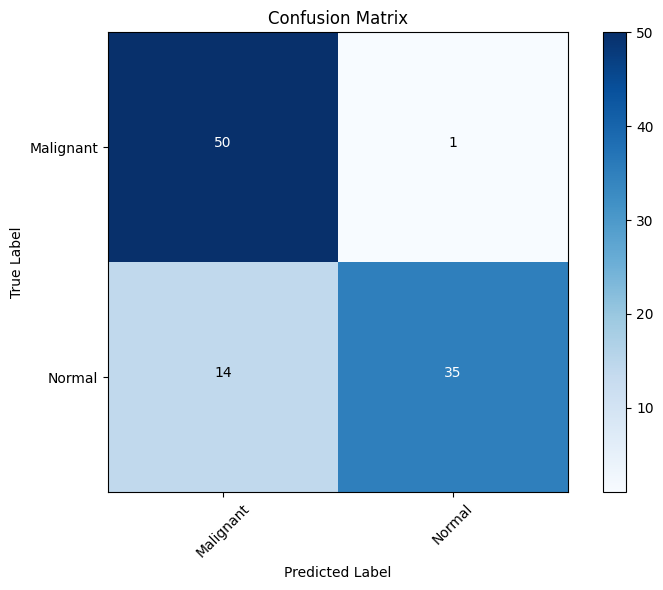

In [145]:
# Define classes
classes = ['Malignant', 'Normal']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

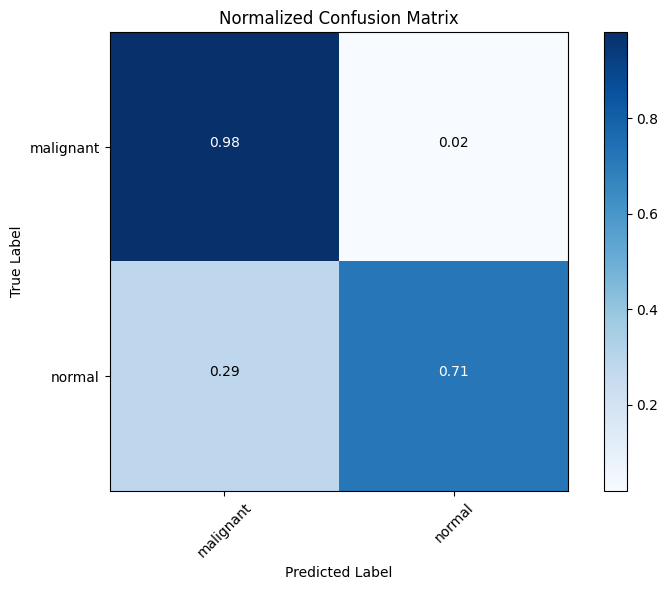

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=45)
plt.yticks(tick_marks, test_generator.class_indices)

# Add text annotations
fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [140]:
# Get the true labels for the entire test dataset
all_true_labels = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

# Predict labels for the entire test dataset
all_pred_labels = best_model.model.predict(test_generator).flatten()
all_pred_labels = (all_pred_labels > 0.5).astype(int)

# Generate the classification report
classification_rep = classification_report(all_true_labels, all_pred_labels)

# Print the classification report
print("Classification Report based on the entire test set:\n", classification_rep)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
Classification Report based on the entire test set:
               precision    recall  f1-score   support

         0.0       0.71      0.98      0.82        50
         1.0       0.97      0.60      0.74        50

    accuracy                           0.79       100
   macro avg       0.84      0.79      0.78       100
weighted avg       0.84      0.79      0.78       100



In [146]:
from sklearn.metrics import accuracy_score

# Calculate test accuracy based on the entire test set
test_accuracy = accuracy_score(all_true_labels, all_pred_labels)

# Print the test accuracy
print("Test Accuracy based on the entire test set:", test_accuracy)


Test Accuracy based on the entire test set: 0.79
